In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
train_path = Path('../Data/cats_dogs_dataset/train/')
test_path = Path('../Data/cats_dogs_dataset/valid/')

In [3]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df(train_path):
    files = filelist(train_path, '.txt')
    annotations = []
    for file in files:
        filedata = {}
        label, xmin, ymin, xmax, ymax = open(file, 'r').readline().split()
        filedata['filename'] = file.replace('.txt', '.jpg')
        filedata['class'] = label
        filedata['xmin'] = xmin
        filedata['ymin'] = ymin
        filedata['xmax'] = xmax
        filedata['ymax'] = ymax
        annotations.append(filedata)
    return pd.DataFrame(annotations)

In [4]:
df_train = generate_train_df(train_path)
print(df_train.shape)
df_train.head()

(2985, 6)


,class,filename,xmax,xmin,ymax,ymin
0,2,../Data/cats_dogs_dataset/train/chihuahua_15.jpg,341,115,255,106
1,2,../Data/cats_dogs_dataset/train/miniature_pins...,153,68,67,6
2,1,../Data/cats_dogs_dataset/train/Abyssinian_119...,156,39,179,51
3,2,../Data/cats_dogs_dataset/train/samoyed_129.jpg,263,39,320,21
4,2,../Data/cats_dogs_dataset/train/staffordshire_...,257,125,173,50


In [5]:
#label encode target
class_dict = {'1': 0, '2': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [6]:
print(df_train.shape)
df_train.head()

(2985, 6)


,class,filename,xmax,xmin,ymax,ymin
0,1,../Data/cats_dogs_dataset/train/chihuahua_15.jpg,341,115,255,106
1,1,../Data/cats_dogs_dataset/train/miniature_pins...,153,68,67,6
2,0,../Data/cats_dogs_dataset/train/Abyssinian_119...,156,39,179,51
3,1,../Data/cats_dogs_dataset/train/samoyed_129.jpg,263,39,320,21
4,1,../Data/cats_dogs_dataset/train/staffordshire_...,257,125,173,50


In [7]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int32)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[3],x[4],x[2]])

def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(read_path).replace('train', 'resized')
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [8]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = 'images_resized'
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

In [9]:
im = cv2.imread(df_train.values[0][1])
bb = create_bb_array(df_train.values[0])
print(im.shape)
print(bb)

(500, 372, 3)
['106' '115' '255' '341']


In [10]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([106., 115., 254., 340.], dtype=float32)

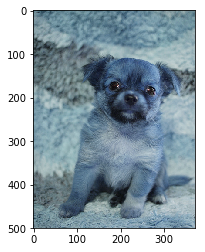

In [11]:
plt.imshow(im)

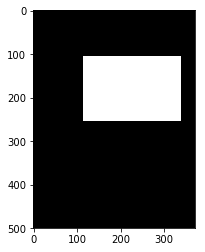

In [12]:
plt.imshow(Y, cmap='gray')

In [13]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [14]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [15]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

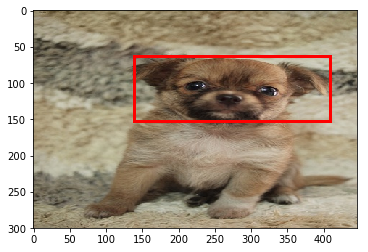

In [16]:
#original
im = cv2.imread(df_train.values[0][6])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[0][7])

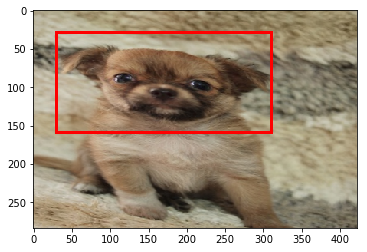

In [17]:
# after transformation
im, bb = transformsXY(df_train.values[0][6], df_train.values[0][7], True)
show_corner_bb(im, bb)


In [18]:
df_train = df_train.reset_index()

In [19]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [22]:
class CatsDogsDataset(Dataset):
    def __init__(self, paths, bb, label, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.label = label.values

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.label[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [23]:
train_ds = CatsDogsDataset(X_train['new_path'], X_train['new_bb'] ,y_train, transforms=True)
valid_ds = CatsDogsDataset(X_val['new_path'], X_val['new_bb'],y_val)

In [24]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [25]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 2))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [26]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [27]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10, C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            # x = x.float()
            x = x.cuda().float()
            # y_class = y_class
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            # y_bb = y_bb.float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [28]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        # x = x.float()
        # y_class = y_class
        # y_bb = y_bb.float()
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [29]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [30]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=12)

KeyboardInterrupt: 

In [31]:
# choose random image from validation set
X_val

,new_path,new_bb
93,../Data/cats_dogs_dataset/resized/leonberger_1...,"[73.0, 89.0, 188.0, 227.0]"
2686,../Data/cats_dogs_dataset/resized/shiba_inu_19...,"[40.0, 37.0, 237.0, 234.0]"
2381,../Data/cats_dogs_dataset/resized/saint_bernar...,"[54.0, 143.0, 222.0, 301.0]"
2163,../Data/cats_dogs_dataset/resized/boxer_12.jpg,"[7.0, 0.0, 261.0, 347.0]"
1776,../Data/cats_dogs_dataset/resized/american_pit...,"[8.0, 41.0, 130.0, 312.0]"
2515,../Data/cats_dogs_dataset/resized/boxer_113.jpg,"[45.0, 24.0, 186.0, 355.0]"
2588,../Data/cats_dogs_dataset/resized/Bengal_155.jpg,"[68.0, 51.0, 258.0, 407.0]"
535,../Data/cats_dogs_dataset/resized/Bombay_18.jpg,"[54.0, 38.0, 123.0, 185.0]"
900,../Data/cats_dogs_dataset/resized/saint_bernar...,"[140.0, 143.0, 285.0, 407.0]"
2273,../Data/cats_dogs_dataset/resized/american_bul...,"[53.0, 208.0, 114.0, 332.0]"


In [37]:
# test Dataset
test_ds = CatsDogsDataset(pd.DataFrame([{'path':'../Data/cats_dogs_dataset/valid/Abyssinian_116.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [38]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 484, 323])

In [39]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])

In [40]:
# predicted class
torch.max(out_class, 1)

NameError: name 'out_class' is not defined

In [41]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

NameError: name 'out_bb' is not defined